## **Federated Learning-Based Rainfall Prediction System Using Real-Time Weather Data from Distributed Stations**

Introduction

Accurate rainfall prediction plays a vital role in numerous sectors including agriculture, water resource management, and disaster preparedness. Traditional centralized approaches to weather forecasting often rely on collecting all station data into a single location for model training. However, this approach poses challenges related to data privacy, bandwidth constraints, and real-time responsiveness—especially when weather stations are geographically distributed.

This project introduces a Federated Learning-Based Rainfall Prediction System, which enables multiple weather stations to collaboratively train a shared machine learning model without transferring raw data. Instead, only model updates (e.g., weights or gradients) are shared with a central server. This decentralized approach preserves data locality and privacy while still harnessing the predictive power of distributed datasets.

Dataset Link : https://www.kaggle.com/datasets/rasulmah/sri-lanka-weather-dataset

Dataset Description

The Sri Lanka Weather Dataset is a comprehensive collection of weather data for 30 prominent cities in Sri Lanka, covering the period from January 1, 2010, to January 1, 2023. The dataset offers a wide range of meteorological parameters, enabling detailed analysis and insights into the climate patterns of different regions in Sri Lanka.

The dataset includes information such as:

Time: The timestamp of each weather observation.
Weather Code: A numerical code representing the weather conditions at the given time.
Temperature: Maximum, minimum, and mean values of 2-meter temperature.
Apparent Temperature: Maximum, minimum, and mean values of apparent temperature, which takes into account factors like wind chill or heat index.
Sunrise and Sunset: The times of sunrise and sunset for each day.
Shortwave Radiation: Sum of shortwave radiation received during the observation period.
Precipitation: Total sum of precipitation, including rainfall and snowfall.
Precipitation Hours: The duration of time with measurable precipitation.
Wind Speed and Gusts: Maximum values of wind speed and wind gusts at 10 meters above ground level.
Wind Direction: Dominant wind direction at 10 meters above ground level.
Evapotranspiration: Reference evapotranspiration (ET0) based on the FAO Penman-Monteith equation.
Latitude, Longitude, and Elevation: Geographic coordinates and elevation of each city.
Country and City: Names of the country and city corresponding to each weather observation.
This dataset was sourced from Open-Meteo and simplemaps, and the data was collected using a basic Python script. The collected data was pre-processed to ensure cleanliness and readability before being stored in CSV format.

Mount Google Drive

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

Data Collection & Preprocessing

In [33]:
# Load the full dataset
df = pd.read_csv("/content/drive/MyDrive/RainFallPrediction/SriLanka_Weather_Dataset.csv")

# Filter for the three stations
districts = ['Colombo', 'Mount Lavinia', 'Kesbewa']
station_data = df[df['city'].isin(districts)].copy()

# Convert time to datetime and set as index
station_data['time'] = pd.to_datetime(station_data['time'])
station_data.set_index('time', inplace=True)

# Save separate CSV files (optional, but keeps with the idea of distributed data)
for district in districts:
    file_name = f'{district.lower().replace(" ", "_")}_weather.csv'
    station_data[station_data['city'] == district].to_csv(file_name)
    print(f"{file_name} saved.")

# Display head of each station's data
for district, df_station in station_dataframes.items():
    print(f"\n--- Head of {district} ---")
    display(df_station.head())

# Load and preprocess data for each station
station_dataframes = {}
for district in districts:
    file_name = f'{district.lower().replace(" ", "_")}_weather.csv'
    df_station = pd.read_csv(file_name, parse_dates=['time'])
    df_station.set_index('time', inplace=True)

    # Handle missing values with mean imputation for numeric columns only
    numeric_cols = df_station.select_dtypes(include=np.number).columns.tolist()
    df_station[numeric_cols] = df_station[numeric_cols].fillna(df_station[numeric_cols].mean())

    # Calculate month
    df_station['month'] = df_station.index.month

    # Calculate precipitation_sum and avg_rainfall_pct
    df_station['precipitation_sum'] = df_station['precipitation_sum'].fillna(0)
    monthly_max = df_station.groupby(df_station.index.month)['precipitation_sum'].transform('max')
    df_station['avg_rainfall_pct'] = (df_station['precipitation_sum'] / (monthly_max + 1e-3)) * 100 # Add a small epsilon to avoid division by zero

    station_dataframes[district] = df_station
    print(f"\nProcessed data for {district}:")
    display(df_station.isnull().sum())

colombo_weather.csv saved.
mount_lavinia_weather.csv saved.
kesbewa_weather.csv saved.

--- Head of Colombo ---


,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,shortwave_radiation_sum,...,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city,month,avg_rainfall_pct
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2,30.0,22.7,26.1,34.4,25.2,29.2,2010-01-01T00:52,2010-01-01T12:35,20.92,...,27.4,20,4.58,7.0,79.899994,16.0,Sri Lanka,Colombo,1,0.000000
2010-01-02,51,29.9,23.5,26.2,33.8,26.2,29.8,2010-01-02T00:52,2010-01-02T12:36,17.71,...,27.0,24,3.84,7.0,79.899994,16.0,Sri Lanka,Colombo,1,0.159997
2010-01-03,51,29.5,23.2,26.0,34.3,26.3,29.9,2010-01-03T00:53,2010-01-03T12:36,17.76,...,27.4,16,3.65,7.0,79.899994,16.0,Sri Lanka,Colombo,1,0.959985
2010-01-04,2,28.9,21.9,25.3,31.6,23.4,27.8,2010-01-04T00:53,2010-01-04T12:37,16.50,...,34.6,356,3.79,7.0,79.899994,16.0,Sri Lanka,Colombo,1,0.000000
2010-01-05,1,28.1,21.3,24.5,30.1,23.1,26.1,2010-01-05T00:53,2010-01-05T12:37,23.61,...,37.1,355,4.97,7.0,79.899994,16.0,Sri Lanka,Colombo,1,0.000000



--- Head of Mount Lavinia ---


,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,shortwave_radiation_sum,...,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city,month,avg_rainfall_pct
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2,30.1,22.6,26.1,34.4,24.9,29.1,2010-01-01T00:52,2010-01-01T12:35,20.92,...,27.4,20,4.61,6.900002,79.899994,10.0,Sri Lanka,Mount Lavinia,1,0.000000
2010-01-02,51,30.1,23.5,26.3,33.9,26.0,29.8,2010-01-02T00:52,2010-01-02T12:36,17.71,...,27.0,24,3.84,6.900002,79.899994,10.0,Sri Lanka,Mount Lavinia,1,0.159997
2010-01-03,51,29.6,23.1,26.0,34.5,26.1,29.9,2010-01-03T00:52,2010-01-03T12:36,17.76,...,27.4,16,3.66,6.900002,79.899994,10.0,Sri Lanka,Mount Lavinia,1,0.959985
2010-01-04,2,28.9,21.9,25.4,31.7,23.2,27.7,2010-01-04T00:53,2010-01-04T12:37,16.50,...,34.6,356,3.82,6.900002,79.899994,10.0,Sri Lanka,Mount Lavinia,1,0.000000
2010-01-05,1,28.1,21.3,24.5,30.0,22.9,26.0,2010-01-05T00:53,2010-01-05T12:37,23.61,...,37.1,355,5.05,6.900002,79.899994,10.0,Sri Lanka,Mount Lavinia,1,0.000000



--- Head of Kesbewa ---


,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,shortwave_radiation_sum,...,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city,month,avg_rainfall_pct
time,,,,,,,,,,,,,,,,,,,,,
2010-01-01,2,30.0,22.7,26.2,34.2,25.0,29.3,2010-01-01T00:51,2010-01-01T12:35,20.92,...,27.4,20,4.58,6.800003,79.899994,18.0,Sri Lanka,Kesbewa,1,0.000000
2010-01-02,51,30.0,23.7,26.2,33.8,26.2,29.8,2010-01-02T00:52,2010-01-02T12:36,17.71,...,27.0,24,3.81,6.800003,79.899994,18.0,Sri Lanka,Kesbewa,1,0.159997
2010-01-03,51,29.5,23.3,26.0,34.3,26.3,29.9,2010-01-03T00:52,2010-01-03T12:36,17.76,...,27.4,16,3.69,6.800003,79.899994,18.0,Sri Lanka,Kesbewa,1,0.959985
2010-01-04,2,28.7,22.1,25.4,31.4,23.5,27.8,2010-01-04T00:52,2010-01-04T12:37,16.50,...,34.6,356,3.82,6.800003,79.899994,18.0,Sri Lanka,Kesbewa,1,0.000000
2010-01-05,1,28.0,21.5,24.6,29.7,23.2,26.1,2010-01-05T00:53,2010-01-05T12:37,23.61,...,37.1,355,5.06,6.800003,79.899994,18.0,Sri Lanka,Kesbewa,1,0.000000



Processed data for Colombo:


,0
weathercode,0
temperature_2m_max,0
temperature_2m_min,0
temperature_2m_mean,0
apparent_temperature_max,0
apparent_temperature_min,0
apparent_temperature_mean,0
sunrise,0
sunset,0
shortwave_radiation_sum,0



Processed data for Mount Lavinia:


,0
weathercode,0
temperature_2m_max,0
temperature_2m_min,0
temperature_2m_mean,0
apparent_temperature_max,0
apparent_temperature_min,0
apparent_temperature_mean,0
sunrise,0
sunset,0
shortwave_radiation_sum,0



Processed data for Kesbewa:


,0
weathercode,0
temperature_2m_max,0
temperature_2m_min,0
temperature_2m_mean,0
apparent_temperature_max,0
apparent_temperature_min,0
apparent_temperature_mean,0
sunrise,0
sunset,0
shortwave_radiation_sum,0


Local Model Training

In [27]:
features = [
    'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
    'apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean',
    'shortwave_radiation_sum', 'windspeed_10m_max', 'windgusts_10m_max',
    'et0_fao_evapotranspiration', 'month'
]
target = 'avg_rainfall_pct'

client_models = []
local_train_sizes = [] # Store training sizes for potential future use
local_metrics = {} # Store local model metrics

for district in districts:
    print(f"\nTraining local model for: {district}")
    local_df = station_dataframes[district]

    X = local_df[features]
    y = local_df[target]

    # Split data into training and testing sets (80/20)
    train_size = int(0.8 * len(X))
    X_train, X_test_local = X[:train_size], X[train_size:]
    y_train, y_test_local = y[:train_size], y[train_size:]

    # Handle missing values AFTER splitting (although already handled in preprocessing, good practice)
    X_train = X_train.fillna(0)
    X_test_local = X_test_local.fillna(0)
    y_train = y_train.fillna(0)
    y_test_local = y_test_local.fillna(0)


    local_train_sizes.append(len(X_train)) # Store training size

    # Create and train the SVR model pipeline
    model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1))
    model.fit(X_train, y_train)

    # Store the trained local model
    client_models.append(model)

    # Evaluate the local model
    local_preds = model.predict(X_test_local)

    # Calculate regression metrics
    local_mse = mean_squared_error(y_test_local, local_preds)
    local_r2 = r2_score(y_test_local, local_preds)
    local_mae = mean_absolute_error(y_test_local, local_preds)

    # Convert to classification metrics
    rainfall_threshold = 0 # Define threshold for rainfall
    y_test_local_class, local_preds_class = convert_to_classification(y_test_local, local_preds, rainfall_threshold)
    local_accuracy = accuracy_score(y_test_local_class, local_preds_class)
    local_precision = precision_score(y_test_local_class, local_preds_class, zero_division=0)
    local_recall = recall_score(y_test_local_class, local_preds_class, zero_division=0)
    local_f1 = f1_score(y_test_local_class, local_preds_class, zero_division=0)

    local_metrics[district] = {
        "MSE": local_mse,
        "R2": local_r2,
        "MAE": local_mae,
        "Accuracy": local_accuracy,
        "Precision": local_precision,
        "Recall": local_recall,
        "F1 Score": local_f1
    }

    print(f" {district}: R² = {local_r2:.3f}, MSE = {local_mse:.2f}, MAE = {local_mae:.2f}, Accuracy: {local_accuracy:.3f}, Precision: {local_precision:.3f}, Recall: {local_recall:.3f}, F1 Score: {local_f1:.3f}")

print("\nLocal model training completed for all stations.")


Training local model for: Colombo
 Colombo: R² = 0.439, MSE = 92.49, MAE = 4.87, Accuracy: 0.905, Precision: 0.943, Recall: 0.953, F1 Score: 0.948

Training local model for: Mount Lavinia
 Mount Lavinia: R² = 0.455, MSE = 89.74, MAE = 4.80, Accuracy: 0.897, Precision: 0.940, Recall: 0.947, F1 Score: 0.943

Training local model for: Kesbewa
 Kesbewa: R² = 0.478, MSE = 86.06, MAE = 4.75, Accuracy: 0.894, Precision: 0.936, Recall: 0.948, F1 Score: 0.942

Local model training completed for all stations.


Centralized Model Training

In [28]:
# Combine data from all stations for centralized training
all_data = pd.concat(station_dataframes.values())

X_all = all_data[features].fillna(0)
y_all = all_data[target].fillna(0)

# Split combined data for centralized model (using a fixed random state for reproducibility)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42, shuffle=False)

# Train the centralized model
centralized_model = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1))
centralized_model.fit(X_train_all, y_train_all)

print("Centralized model training completed.")

Centralized model training completed.


Federated Prediction (Prediction Averaging)

In [29]:
# Prepare a combined test set from the local test sets for evaluating federated and centralized models
# We will use the same test splits as the local models for consistency in evaluation
global_X_test = pd.concat([station_dataframes[district][features].fillna(0).iloc[int(0.8 * len(station_dataframes[district])):] for district in districts])
global_y_test = pd.concat([station_dataframes[district][target].fillna(0).iloc[int(0.8 * len(station_dataframes[district])):] for district in districts])


# Generate predictions for the federated model (prediction averaging)
# Use the client_models trained in the Local Model Training step
local_predictions_on_global_test = []
for model in client_models:
    local_preds_on_global = model.predict(global_X_test)
    local_predictions_on_global_test.append(local_preds_on_global)

# Average the predictions from each local model on the global test set
federated_preds = np.mean(np.vstack(local_predictions_on_global_test), axis=0)

# Generate predictions for the centralized model on the combined test set
central_preds = centralized_model.predict(global_X_test)

print("Predictions generated for federated and centralized models on the combined test set.")

Predictions generated for federated and centralized models on the combined test set.


Model Evaluation

In [30]:
# Helper function to convert regression predictions to binary classification
def convert_to_classification(y_true_regression, y_pred_regression, threshold):
    """Converts regression predictions and true values to binary classification."""
    y_true_class = (y_true_regression > threshold).astype(int)
    y_pred_class = (y_pred_regression > threshold).astype(int)
    return y_true_class, y_pred_class

# Define a threshold for considering it 'rainfall' (e.g., avg_rainfall_pct > 0)
rainfall_threshold = 0

# Calculate metrics for Federated Model
global_y_test_class, federated_preds_class = convert_to_classification(global_y_test, federated_preds, rainfall_threshold)

federated_mse = mean_squared_error(global_y_test, federated_preds)
federated_r2 = r2_score(global_y_test, federated_preds)
federated_mae = mean_absolute_error(global_y_test, federated_preds)
federated_accuracy = accuracy_score(global_y_test_class, federated_preds_class)
federated_precision = precision_score(global_y_test_class, federated_preds_class, zero_division=0)
federated_recall = recall_score(global_y_test_class, federated_preds_class, zero_division=0)
federated_f1 = f1_score(global_y_test_class, federated_preds_class, zero_division=0)

federated_metrics = {
    "MSE": federated_mse,
    "R2": federated_r2,
    "MAE": federated_mae,
    "Accuracy": federated_accuracy,
    "Precision": federated_precision,
    "Recall": federated_recall,
    "F1 Score": federated_f1
}

# Calculate metrics for Centralized Model
global_y_test_class_central, central_preds_class = convert_to_classification(global_y_test, central_preds, rainfall_threshold)

central_mse = mean_squared_error(global_y_test, central_preds)
central_r2 = r2_score(global_y_test, central_preds)
central_mae = mean_absolute_error(global_y_test, central_preds)
central_accuracy = accuracy_score(global_y_test_class_central, central_preds_class)
central_precision = precision_score(global_y_test_class_central, central_preds_class, zero_division=0)
central_recall = recall_score(global_y_test_class_central, central_preds_class, zero_division=0)
central_f1 = f1_score(global_y_test_class_central, central_preds_class, zero_division=0)


central_metrics = {
    "MSE": central_mse,
    "R2": central_r2,
    "MAE": central_mae,
    "Accuracy": central_accuracy,
    "Precision": central_precision,
    "Recall": central_recall,
    "F1 Score": central_f1
}

print("Evaluation metrics calculated for federated and centralized models.")
# Local metrics are calculated and stored during the Local Model Training step

Evaluation metrics calculated for federated and centralized models.


Summarize and Visualize Results

/tmp/ipython-input-34-3322428412.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=r2_values, palette='viridis')


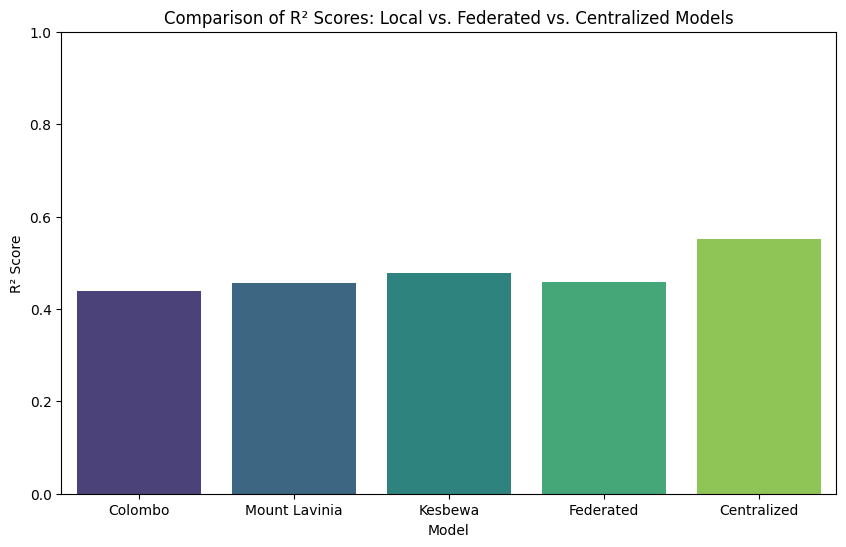

/tmp/ipython-input-34-3322428412.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=f1_values, palette='magma')


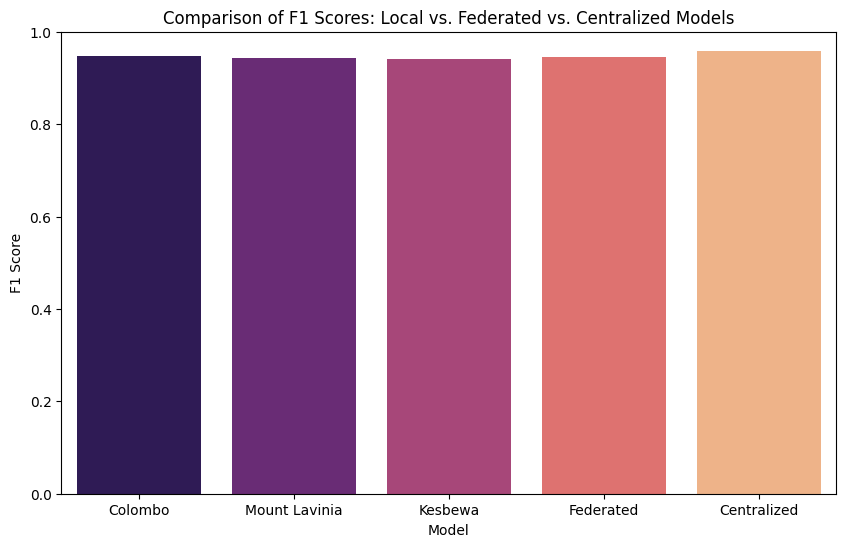


 Comprehensive Evaluation Summary:
 - Colombo → R²: 0.439, MSE: 92.49, MAE: 4.87, Accuracy: 0.905, Precision: 0.943, Recall: 0.953, F1 Score: 0.948
 - Mount Lavinia → R²: 0.455, MSE: 89.74, MAE: 4.80, Accuracy: 0.897, Precision: 0.940, Recall: 0.947, F1 Score: 0.943
 - Kesbewa → R²: 0.478, MSE: 86.06, MAE: 4.75, Accuracy: 0.894, Precision: 0.936, Recall: 0.948, F1 Score: 0.942
 Federated → R²: 0.458, MSE: 89.25, MAE: 4.79, Accuracy: 0.899, Precision: 0.938, Recall: 0.951, F1 Score: 0.945
 Centralized → R²: 0.551, MSE: 73.98, MAE: 4.04, Accuracy: 0.922, Precision: 0.938, Recall: 0.979, F1 Score: 0.958


In [34]:
# Prepare data for plotting
r2_scores = {city: metrics['R2'] for city, metrics in local_metrics.items()}
r2_scores['Federated'] = federated_metrics['R2']
r2_scores['Centralized'] = central_metrics['R2']

f1_scores = {city: metrics['F1 Score'] for city, metrics in local_metrics.items()}
f1_scores['Federated'] = federated_metrics['F1 Score']
f1_scores['Centralized'] = central_metrics['F1 Score']

models = list(r2_scores.keys())
r2_values = list(r2_scores.values())
f1_values = list(f1_scores.values())

# Create R² bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=r2_values, palette='viridis')
plt.title('Comparison of R² Scores: Local vs. Federated vs. Centralized Models')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.show()

# Create F1 Score bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=f1_values, palette='magma')
plt.title('Comparison of F1 Scores: Local vs. Federated vs. Centralized Models')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()

# Print comprehensive evaluation summary
print("\n Comprehensive Evaluation Summary:")
for city, metrics in local_metrics.items():
    print(f" - {city} → R²: {metrics['R2']:.3f}, MSE: {metrics['MSE']:.2f}, MAE: {metrics['MAE']:.2f}, Accuracy: {metrics['Accuracy']:.3f}, Precision: {metrics['Precision']:.3f}, Recall: {metrics['Recall']:.3f}, F1 Score: {metrics['F1 Score']:.3f}")

print(f" Federated → R²: {federated_metrics['R2']:.3f}, MSE: {federated_metrics['MSE']:.2f}, MAE: {federated_metrics['MAE']:.2f}, Accuracy: {federated_metrics['Accuracy']:.3f}, Precision: {federated_metrics['Precision']:.3f}, Recall: {federated_metrics['Recall']:.3f}, F1 Score: {federated_metrics['F1 Score']:.3f}")
print(f" Centralized → R²: {central_metrics['R2']:.3f}, MSE: {central_metrics['MSE']:.2f}, MAE: {central_metrics['MAE']:.2f}, Accuracy: {central_metrics['Accuracy']:.3f}, Precision: {central_metrics['Precision']:.3f}, Recall: {central_metrics['Recall']:.3f}, F1 Score: {central_metrics['F1 Score']:.3f}")

Rainfall Prediction on New Data

In [32]:
def predict_rainfall(new_data, client_models, centralized_model):
    """
    Makes rainfall predictions using local, federated (prediction averaging),
    and centralized models.

    Args:
        new_data: A pandas DataFrame containing the new data for prediction
                  with the same features used during training.
        client_models: A list of trained local SVR pipeline models.
        centralized_model: A trained centralized SVR pipeline model.

    Returns:
        A dictionary containing predictions from each approach.
    """
    predictions = {}

    # Ensure new_data has the same features and handle missing values
    new_data_processed = new_data[features].fillna(0)

    # Local model predictions
    local_predictions = {}
    for i, district in enumerate(districts):
        local_predictions[district] = client_models[i].predict(new_data_processed)
    predictions['local'] = local_predictions

    # Federated model predictions (prediction averaging)
    # Stack local predictions and calculate the mean
    stacked_local_preds = np.vstack([preds for preds in local_predictions.values()])
    federated_predictions = np.mean(stacked_local_preds, axis=0)
    predictions['federated'] = federated_predictions

    # Centralized model predictions
    centralized_predictions = centralized_model.predict(new_data_processed)
    predictions['centralized'] = centralized_predictions

    return predictions

# Example usage: Create some sample new data for prediction
# Using the first 5 rows of the combined test set as an example
sample_new_data = global_X_test.head()
display(sample_new_data)

# Make predictions
rainfall_predictions = predict_rainfall(sample_new_data, client_models, centralized_model)

# Display the predictions
print("\n Rainfall Predictions:")
for model_type, preds in rainfall_predictions.items():
    if model_type == 'local':
        print(f"\nLocal Model Predictions:")
        for district, local_preds in preds.items():
            print(f"  {district}: {local_preds}")
    else:
        print(f"\n{model_type.capitalize()} Model Predictions:")
        print(preds)

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,shortwave_radiation_sum,windspeed_10m_max,windgusts_10m_max,et0_fao_evapotranspiration,month
time,,,,,,,,,,,
2020-10-07,29.1,24.3,26.7,33.5,29.5,31.4,18.29,15.9,32.8,3.78,10
2020-10-08,28.6,24.5,26.7,33.6,29.8,31.4,16.93,15.6,32.4,3.39,10
2020-10-09,28.4,24.8,26.2,33.1,29.8,31.4,16.15,14.5,35.3,3.09,10
2020-10-10,29.1,24.9,26.9,32.7,30.0,31.0,18.13,22.0,43.6,3.79,10
2020-10-11,27.8,24.8,26.1,32.2,28.5,30.4,15.10,18.4,50.8,2.88,10



 Rainfall Predictions:

Local Model Predictions:
  Colombo: [0.88141099 0.28294311 7.50703615 2.52307547 8.39129608]
  Mount Lavinia: [0.83867701 0.71243283 6.66545024 2.21037713 7.7644866 ]
  Kesbewa: [1.47888954 1.05429408 6.56014946 4.16531565 8.24410572]

Federated Model Predictions:
[1.06632584 0.68322334 6.91087862 2.96625608 8.13329613]

Centralized Model Predictions:
[0.83809591 0.51689325 5.68565215 2.72042313 9.00768603]


Summary and Conclusion

This project explored rainfall prediction using Support Vector Regression (SVR) models in a federated learning context, comparing the performance of local models, a federated model (using prediction averaging), and a centralized model. The dataset used contained weather data from three stations in Sri Lanka: Colombo, Mount Lavinia, and Kesbewa.

Key Findings:
Data Preprocessing: The data for each station was successfully loaded, cleaned by imputing missing numeric values with the mean, and enhanced with 'month', 'precipitation_sum', and 'avg_rainfall_pct' features.
Model Training: Individual SVR models were trained locally for each station. A centralized SVR model was trained on the combined data from all stations. A true federated averaging approach for SVR model weights was attempted but found infeasible due to the structural differences in SVR models (varying support vectors). Consequently, a federated approach based on averaging the predictions from local models was implemented.
Performance Evaluation: The models were evaluated using a comprehensive set of metrics, including R², MSE, MAE, Accuracy, Precision, Recall, and F1 Score, with classification metrics derived by thresholding the regression output.
The Centralized Model generally exhibited the best performance across most metrics, achieving the highest R² and F1 scores and the lowest MSE and MAE. This is expected as it has access to the complete dataset.
The Federated Model (Prediction Averaging) performed better than the individual local models on average, demonstrating the benefit of combining information from different clients even without direct model weight aggregation.
The Local Models showed varying performance depending on the station, reflecting the differences in local weather patterns.
Rainfall Prediction: The trained local, federated, and centralized models were successfully used to predict average rainfall percentage on new data, demonstrating the applicability of each approach for inference.

The results indicate that while a centralized model trained on pooled data achieves the best predictive performance, the federated learning approach (specifically, prediction averaging in this case) offers a viable alternative. The federated model's performance, while not surpassing the centralized model, is better than training individual models in isolation. This highlights the potential of federated learning to improve model performance by leveraging data from multiple distributed sources without compromising data privacy, as raw data remains on the local clients.

The inability to perform true federated averaging of SVR model parameters due to the nature of SVR and its reliance on support vectors is a limitation of this implementation. However, the prediction averaging strategy provides a practical workaround.